In [29]:
import torch
import numpy as np
import matplotlib.pylab as pl
import sklearn
from sklearn import datasets
import ot
import proplot as plot
plot.rc['figure.facecolor'] = "white"

In [30]:
if torch.cuda.is_available():
    device='cuda'
    dtype = torch.cuda.DoubleTensor
else:
    device='cpu'
    dtype=torch.DoubleTensor
print(device)

device='cpu'
dtype=torch.DoubleTensor
torch.set_default_tensor_type(dtype)

cuda


In [31]:
import sys
sys.path.append('../code/')

In [32]:
from generate_data import make_data
from SWGG import SWGG_CP
from utils import random_slice

In [33]:
def maxSW2(xs,xt,proj): #add a seed?
    
    xs_line=torch.matmul(xs.float(),proj[:,None].float())
    xt_line=torch.matmul(xt.float(),proj[:,None].float())
    
    xs_line_sorted,_=torch.sort(xs_line,axis=0)
    xt_line_sorted,_=torch.sort(xt_line,axis=0)
    W_1d = torch.sum((xs_line_sorted-xt_line_sorted)**2)
    
    return W_1d

In [34]:
def get_maxSW(Xa,Xb,lr=1e-3,num_iter=500):
    init=torch.ones(Xa.shape[1],requires_grad=True, device=Xa.device, dtype=Xa.dtype)
    theta=init
    #theta = torch.tensor([init], requires_grad=True, device=Xa.device, dtype=Xa.dtype)
    optimizer = torch.optim.Adam([theta], lr=lr)
    loss_l=[]
    proj = theta/torch.norm(theta)
    for i in range(num_iter):
        # build projector
        loss = -maxSW2(Xa.float(),Xb.float(),proj.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_l.append(-loss.data)
        proj = theta/torch.norm(theta)
    return theta, loss_l

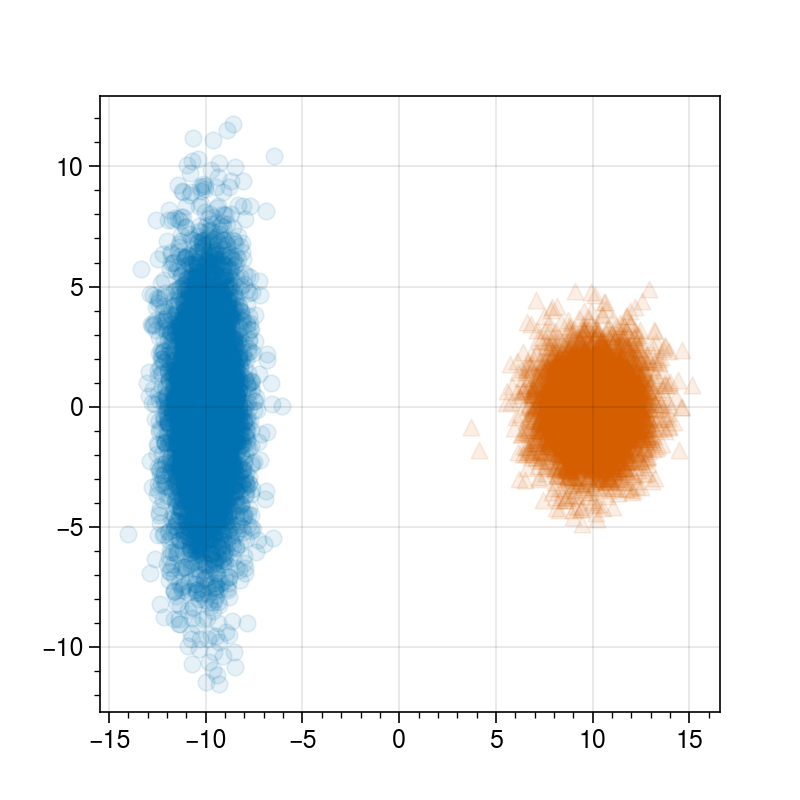

In [35]:
d=2
n_samples=5000
mu_s=np.array([-10,0])
cov_s=np.array([1,11])
cov_s = cov_s * np.eye(d)

mu_t=np.array([10,0])
cov_t=np.array([2,2])
cov_t = cov_t * np.eye(d)
xs = np.random.multivariate_normal(mu_s, cov_s, n_samples)
xt = np.random.multivariate_normal(mu_t, cov_t, n_samples)

X = torch.from_numpy(xs).to(device)
Y = torch.from_numpy(xt).to(device)
X=X.float()
Y=Y.float()

pl.figure()
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.1)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Source',alpha=0.1,marker="^")

In [36]:
theta=random_slice(100,d).T.float()
W,_,_=SWGG_CP(X,Y,theta)
idx=torch.argmin(W)
theta_opt=theta[:,idx]

In [37]:
theta_opt2,_=get_maxSW(X,Y,lr=1e-2,num_iter=100)
theta_opt2.requires_grad = False

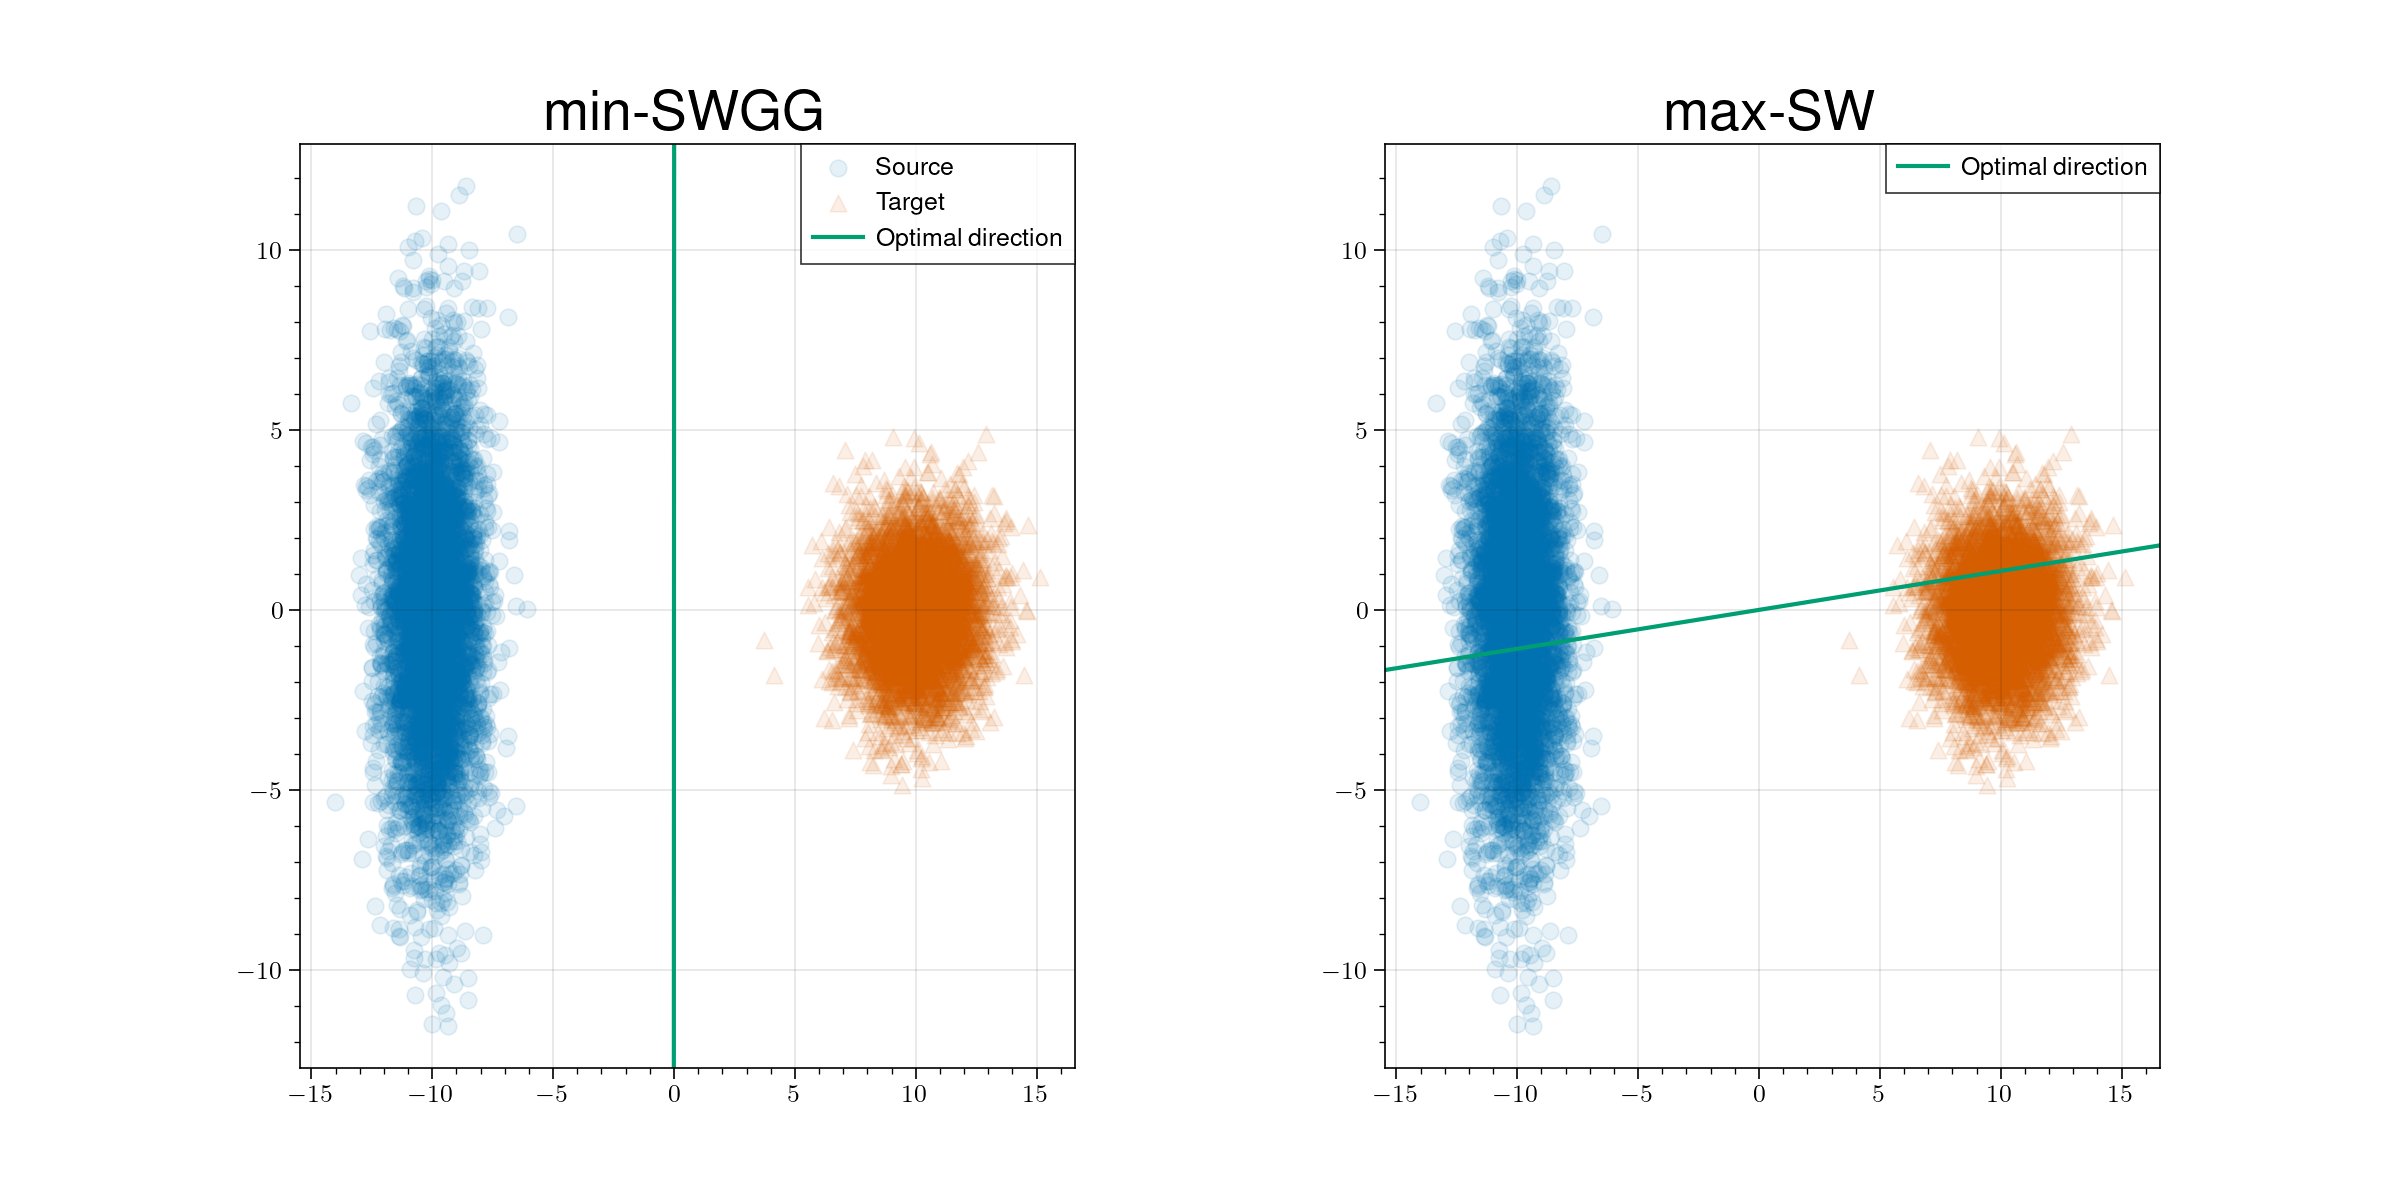

In [38]:

pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

pl.figure(figsize=(12,6))
grid = pl.GridSpec(1, 2, wspace=0.4, hspace=0.3)

pl.subplot(grid[0, 0])
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source',alpha=0.1)
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target',alpha=0.1,marker="^")
pl.axline((0,0), [theta_opt[0],theta_opt[1]], color='C2',label='Optimal direction')
pl.title('min-SWGG',size=20)
pl.legend()

pl.subplot(grid[0, 1])
pl.scatter(X[:, 0], X[:, 1], c='C0',alpha=0.1)
pl.scatter(Y[:, 0], Y[:, 1], c='C1',alpha=0.1,marker="^")
pl.axline((0,0), [theta_opt2[0],theta_opt2[1]], color='C2',label='Optimal direction')
pl.title('max-SW',size=20)
pl.legend()
pl.savefig("diff_maxSW_minSWGG.pdf",bbox_inches='tight')
pl.show()